In [1]:
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests

In [2]:
final = 'dataset.db'

conn = sqlite3.connect(final)
cursor = conn.cursor()

cursor.execute('SELECT * from vacancies')
final_db = cursor.fetchall()
conn.close()

In [3]:
final_db[9]

('29664146',
 'Системный администратор Oracle',
 'Москва',
 'Сбербанк',
 '2019-01-15T14:00:05+0300',
 '<p><strong>Функционал:</strong></p> <ul> <li>Круглосуточный мониторинг за состоянием промышленных СУБД Oracle Банка;</li> <li>Выполнение работ по сопровождению промышленных и тестовых СУБД по подготовленным планам, инструкциям;</li> <li>Сбор и анализ диагностической информации, в случае потребности;</li> <li>Устранение неисправностей в работе промышленных СУБД;</li> <li>Поддержание актуальности информации в системах мониторинга;</li> </ul> <p><strong>Требования:</strong></p> <ul> <li>Опыт работы в сфере сопровождения/администрирования СУБД от 3х лет;</li> <li>Опыт работы в области настройки мониторинга СУБД, объектов БД;</li> <li>Знание стека протоколов TCP/IP;</li> <li>Знание и понимание общих принципов работы реляционных СУБД;</li> <li>Знание ОС Linux/AIX/Solaris на уровне продвинутого пользователя;</li> <li>Понимание OLAP/OLTP технологий;</li> </ul> <p><strong>Условия работы:</stro

### Кусок кода из блокнота "Разделение на мысли"
    объяснение того, почему мы все-таки немного недоработали обработку базы вакансий

In [4]:
filtered_db = 'data_set.db'

conn = sqlite3.connect(filtered_db)
cursor = conn.cursor()

cursor.execute('SELECT * from vacancies')
filtered = cursor.fetchall()
conn.close()

In [13]:
filtered[11]

('29673097',
 'Системный аналитик',
 'Москва',
 'Сбербанк',
 '2019-01-15T19:30:04+0300',
 '<div><p></p><p>Краткое описание </p><p></p><p>Ищем ответственного и проактивного аналитика, способного совмещать в себе роли бизнес и системного аналитика, а также выступать в роли драйвера процессов в команде разработки. В основе проекта лежит автоматизированная система «ДРУГ», состоящая из следующих компонентов: web-интерфейс, мобильное приложение, REST-API и back-end на базе HPSM. Каждый день в системе АС ДРУГ создаются и исполняются десятки тысяч заявок. Ради удовлетворенности пользователей мы стараемся повышать качество нашего продукта: раз в три недели доводим до эксплуатации новые релизы АС ДРУГ.</p><p><strong>Обязанности:</strong></p><ul><li>Сбор и формализация бизнес-требований;</li></ul><ul><li>Разработка и согласование с архитектором АС системных требований;</li></ul><ul><li>Управление исполнением в рамках разработанных требований (координация работ);</li></ul><ul><li>Проведение демонс

In [5]:
main_list = []
for i in filtered:
    if "strong" in i[5]:
        texttest = i[5]
        teststrong = texttest.split('<strong>')
        cur_list = [j.split('</strong>') for j in teststrong if '</strong>' in j] 
        main_list.append(cur_list)

In [15]:
requir = []
counter = {}
for i in range(1164):
    counter[i] = 0
    for j in main_list[i]:
        for k in keywords: # немножко другие keywords -> из-за этого 1622, а не 1619
            if k in j[0].lower():
                requir.append(j[1])
                counter[i] += 1
len(requir) # число больше изначального количества вакансий, потому что из некоторых описаний бралось несколько абзацев

1622

In [16]:
len([x for x in counter if counter[x] == 0]) # те вакансии, для которых ничего не отобрано

188

In [17]:
len([x for x in counter if counter[x] > 1]) # те вакансии, в описании которых подошло несколько заголовков (абзацев)
                                            # при этом необязательно, что из каждого что-то взялось

352

In [18]:
1215 - 1164 + 188 # суммарное количество необработанных вакансий

239

### Составление списка требований для каждой вакансии ( + добавить частотный анализ ключ. слов)
+ анализ слов, встречающихся в названии
+ проработка нестандартных вариантов     

In [19]:
punct = ',«•»∙!"#$%&\'()*+-./:;<=>?@[\\]^_`{|}~'
table = str.maketrans({key: None for key in punct})

In [20]:
# этот список неполный! при желании можно добавить слов для более точного отсева

keywords = ['требования', 'требуется', 'если', 'ждем', 'ждём', 
            'ожидаем', 'ищем', 'будет', 'компетенции', 'плюсом', 'желательно'
            'знание', 'стек', 'стэк', 'технологии', 'навыки', 'обязательно', 
            'от вас', 'опыт', 'ожидания', 'плюсами', 'хотели бы видеть']

In [21]:
# нужный нам заголовок может лежать в 'span', 'p', <p>__<br/>, два стронга подряд...
# этот код все это не учитывает - тоже можно улучшить при желании (если будет время)


errors = []
descs_d = {}
for job in final_db:
    text = job[5]
    descs_d[job[0]] = []
    if '<strong>' in text:
        paragraphs = [x.split('</strong>') for x in text.split('<strong>') if '</strong>' in x]
        for par in paragraphs:
            if set(par[0].lower().translate(table).split()) & set(keywords) != set():
                descs_d[job[0]] += list(filter(None, re.compile("<[^>]*>").split(re.sub('> +<', '', par[1]))))
        if descs_d[job[0]] == []:
            errors.append(job[0])
    else:
        errors.append(job[0])

In [22]:
len(errors) # общее количество "невзятых" объявлений

277

In [23]:
new_punct = '«•»∙!"#$%&\'()*+-.:;<=>?@[\\]^_`{|}~'
new_table = str.maketrans({key: None for key in new_punct})

In [24]:
# привели требования к нормальному виду

for id_ in descs_d:
    descs_d[id_] = list(map(lambda x: x.lower().translate(new_table).strip(), descs_d[id_]))

In [25]:
descs_d['29654783']

['законченное высшее образование по направлению информационные технологии',
 'желателен опыт работы в сфере ит сопровождение рабочих мест, инфраструктуры, серверов, корпоративной телефонии',
 'экспертное знание ms windows 7/10, ms office 2010/2016',
 'опыт работы/администрирования macos/ios, linux',
 'опыт поддержки пк, системного по, в тч навыки удаленного администрирования',
 'пк под управлением windows',
 'знание технического устройства пк и его аппаратных составляющих',
 'стрессоустойчивость, ответственность, коммуникабельность']

In [26]:
sum([len(descs_d[id_]) for id_ in descs_d]) # суммарное количество требований (flatten)

8462

### Получение списка технологий ( + добавить частотный анализ встречающихся технологий (слов))
    1. выкачка с википедии
    2. доп. анализ получившихся требований с целью обнаружения английский названий
    3. добавление аббревиатур

In [27]:
link = 'https://ru.wikipedia.org/wiki/Список_языков_программирования_по_категориям'
alphabet = 'абвгдеёжзийклмнопрстуфхцчщшьыъэюя'

In [28]:
soup = BeautifulSoup(requests.get(link).text, 'lxml')

In [29]:
base = [y for y in [x.text.lower() for x in soup.findAll('li')][20:-67] if set(y) & set(alphabet) == set()]
len(base)

161

In [30]:
base[-5:]

['lolcode', 'malbolge', 'piet', 'whitespace', 'emptyscript']

In [31]:
monosyllabic = [x for x in base if len(x.split()) == 1] # односложные названия
monosyllabic[:7]

['aspectc++', 'aspectj', 'caesarj', 'compose*', 'objectteams', 'basic', 'cg']

In [32]:
# то, над чем трудилась Катя

with open('hard-skills.txt', 'r', encoding='utf-8') as file:
    data = file.read().splitlines()

In [33]:
techs = ['office', 'windows', 'macos', 'linux', 'web', 'html', 
        'javascript', 'java', 'css', 'angularjs', 'reactjs', 
        'git', 'cvs', 'sql', 'node', 'soap', 'rest', 'agile', 
        'navision', 'c#', 'c++', 'assembler', 'windbg', 'TFS', 
        'Preforcescala', 'perl', 'awk', 'bash', 'orm', 'вебфреймворки', 
        'soap', 'ml', 'dm', 'sas baseguideminer', 'pydata', 'pandas', 
        'numpy', 'skipy', 'scikitlearn', 'kerastensoflow', 'django', 
        'python', 'shell', 'teradata', 'perl', 'ruby', 'субд', 'oracle', 
        'mssql', 'gcc', 'llvm', 'itil', 'cobit', 'btc', 'mvc', 'mvvm', 'ioc', 
        'di', 'dagger', 'android', 'object', 'ivec', 'cpu', 'logreg', 'svm', 
        'decision trees', 'gradientboosting', 'svd', 'pca', 'cnn', 'lstm,ооп', 
        'solid', 'ioc', 'gof', 'jquery', 'learning', 'ibm', 'hp', 'vmware', 
        'citrix', 'nginx', 'xml', 'nix', 'hlha', 'iis', 'boost', 'selenium', 'ansible']

### Получение вектора технологий по каждой вакансии
    обычная проверка на встрчаемость слова в полном тексте
    
    (-) провести доп. аналитику и убрать супер-непопулярные технологии!

In [35]:
vectors_d = {}
for job in final_db:
    vectors_d[job[0]] = {x: 0 for x in techs}
    desc = BeautifulSoup(job[5], 'lxml').text.lower()
    for tech in techs:
        if tech in desc:
            vectors_d[job[0]][tech] = 1

In [36]:
[x for x in vectors_d['29664146'] if vectors_d['29664146'][x] == 1]

['linux', 'субд', 'oracle']

In [37]:
# вакансии, в которых не нашлось ничего из нашего списка технологий
len([z[0] for z in [(x, [y for y in vectors_d[x] if vectors_d[x][y] == 1]) for x in vectors_d] if z[1] == []])

88

In [38]:
list(vectors_d.items())[:5]

[('29654783',
  {'office': 1,
   'windows': 1,
   'macos': 1,
   'linux': 1,
   'web': 0,
   'html': 0,
   'javascript': 0,
   'java': 0,
   'css': 0,
   'angularjs': 0,
   'reactjs': 0,
   'git': 0,
   'cvs': 0,
   'sql': 0,
   'node': 0,
   'soap': 0,
   'rest': 0,
   'agile': 0,
   'navision': 0,
   'c#': 0,
   'c++': 0,
   'assembler': 0,
   'windbg': 0,
   'TFS': 0,
   'Preforcescala': 0,
   'perl': 0,
   'awk': 0,
   'bash': 0,
   'orm': 0,
   'вебфреймворки': 0,
   'ml': 0,
   'dm': 0,
   'sas baseguideminer': 0,
   'pydata': 0,
   'pandas': 0,
   'numpy': 0,
   'skipy': 0,
   'scikitlearn': 0,
   'kerastensoflow': 0,
   'django': 0,
   'python': 0,
   'shell': 0,
   'teradata': 0,
   'ruby': 0,
   'субд': 0,
   'oracle': 0,
   'mssql': 0,
   'gcc': 0,
   'llvm': 0,
   'itil': 0,
   'cobit': 0,
   'btc': 0,
   'mvc': 0,
   'mvvm': 0,
   'ioc': 0,
   'di': 0,
   'dagger': 0,
   'android': 0,
   'object': 0,
   'ivec': 0,
   'cpu': 0,
   'logreg': 0,
   'svm': 0,
   'decision tree

## Кластеризация

In [374]:
import sklearn
sklearn.__version__

'0.19.2'

### Визуализация трендов технологий
    1. частота упоминания одного навыка по месяцам
    2. популярность всех навыков за один месяц (радиальная диаграмма)
    3. популярность всех навыков в конкретной компании
    4. популярность профессий конкретного кластера
    
    
    
    !!!ALERT!!!
    в базе данных dataset.db есть вакансии от декабря 2019 (видимо, они были ре-опубликованы) 
    это может быть проблемой -> можно переделать базу с оригинальными датами публикации из архива
    (в нынешней версии я брал все даты еще раз через api.hh.ru)
    
    обязательно переделать даты в базе данных! - имхо это очень сильно роляет, надо обсудить!
    
    можно убрать декабрь, можно вообще взять только первые 6 месяцев

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import datetime

In [40]:
# да, кансер, ай ноу

month_frequency = {
    '01': {x: 0 for x in techs},
    '02': {x: 0 for x in techs},
    '03': {x: 0 for x in techs},
    '04': {x: 0 for x in techs},
    '05': {x: 0 for x in techs},
    '06': {x: 0 for x in techs},
    '07': {x: 0 for x in techs},
    '08': {x: 0 for x in techs},
    '09': {x: 0 for x in techs},
    '10': {x: 0 for x in techs},
    '11': {x: 0 for x in techs},
    '12': {x: 0 for x in techs}
}

month_names = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
}

month_quantity = {
    '01': 0,
    '02': 0,
    '03': 0,
    '04': 0,
    '05': 0,
    '06': 0,
    '07': 0,
    '08': 0,
    '09': 0,
    '10': 0,
    '11': 0,
    '12': 0
}

In [42]:
for job in final_db:
    month = job[4][:10].split('-')[1]
    id_ = job[0]
    for tech in month_frequency[month]:
        month_frequency[month][tech] += vectors_d[id_][tech]
    month_quantity[month] += 1

In [43]:
month_frequency

{'01': {'office': 9,
  'windows': 26,
  'macos': 9,
  'linux': 37,
  'web': 38,
  'html': 20,
  'javascript': 17,
  'java': 58,
  'css': 18,
  'angularjs': 3,
  'reactjs': 3,
  'git': 63,
  'cvs': 2,
  'sql': 77,
  'node': 6,
  'soap': 14,
  'rest': 31,
  'agile': 28,
  'navision': 0,
  'c#': 26,
  'c++': 20,
  'assembler': 2,
  'windbg': 7,
  'TFS': 0,
  'Preforcescala': 0,
  'perl': 7,
  'awk': 1,
  'bash': 8,
  'orm': 12,
  'вебфреймворки': 0,
  'ml': 31,
  'dm': 8,
  'sas baseguideminer': 0,
  'pydata': 1,
  'pandas': 3,
  'numpy': 3,
  'skipy': 1,
  'scikitlearn': 0,
  'kerastensoflow': 0,
  'django': 0,
  'python': 43,
  'shell': 17,
  'teradata': 4,
  'ruby': 8,
  'субд': 29,
  'oracle': 21,
  'mssql': 0,
  'gcc': 0,
  'llvm': 0,
  'itil': 3,
  'cobit': 2,
  'btc': 0,
  'mvc': 9,
  'mvvm': 1,
  'ioc': 2,
  'di': 36,
  'dagger': 0,
  'android': 9,
  'object': 3,
  'ivec': 1,
  'cpu': 1,
  'logreg': 0,
  'svm': 0,
  'decision trees': 0,
  'gradientboosting': 0,
  'svd': 0,
  'pca'

### 1 тип (базовый)
+ https://devpractice.ru/matplotlib-lesson-2-work-with-pyplot/

In [44]:
# получается шляпа видимо из-за того, что за самый ранний период у нас больше всего объявлений
# значит, нужно брать какую-то более сложную величину (делить на общее количество или еще чего)

[month_frequency[month]['c++'] for month in month_frequency]

[20, 15, 19, 30, 13, 12, 8, 6, 15, 13, 13, 6]

In [45]:
month_quantity

{'01': 174,
 '02': 195,
 '03': 143,
 '04': 152,
 '05': 94,
 '06': 67,
 '07': 54,
 '08': 72,
 '09': 82,
 '10': 78,
 '11': 78,
 '12': 26}

In [66]:
# делю на общее количество

perc_values = [round(month_frequency[month]['python']/month_quantity[month] * 100, 2) for month in month_frequency]
perc_values

[24.71,
 21.03,
 18.18,
 17.11,
 29.79,
 23.88,
 29.63,
 27.78,
 24.39,
 21.79,
 30.77,
 11.54]

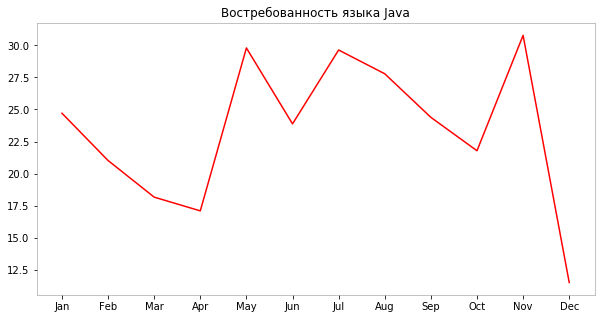

In [73]:
x = [month_names[x] for x in month_names]
y = perc_value('python')

plt.figure(figsize=(10, 5))
plt.plot(x, y, '-r')
plt.title('Востребованность языка Java')
plt.show()

In [48]:
def perc_value(tech):
    global month_frequency, month_quantity
    return [round(month_frequency[month][tech]/month_quantity[month] * 100, 2) for month in month_frequency]

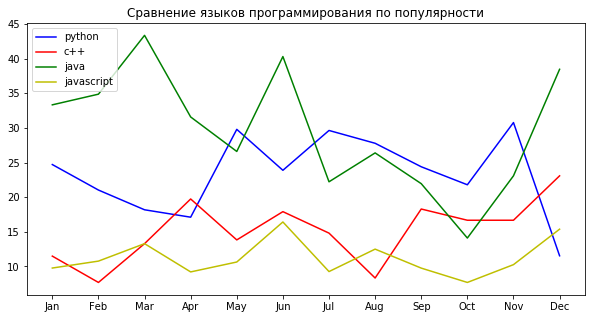

In [49]:
x = [month_names[x] for x in month_names]
y1 = perc_value('python')
y2 = perc_value('c++')
y3 = perc_value('java')
y4 = perc_value('javascript')

plt.figure(figsize=(10, 5))
plt.plot(x, y1, '-b', label='python')
plt.plot(x, y2, '-r', label='c++')
plt.plot(x, y3, '-g', label='java')
plt.plot(x, y4, '-y', label='javascript')
#lt.plot(x, y1, '-b', x, y2, '-r', x, y3, '-g', x, y4, '-y')
plt.title('Сравнение языков программирования по популярности')
plt.legend()
plt.show()

### 2 тип (радиальная диаграмма)
+ уточнить отображение "шага" на диаграмме

In [50]:
from math import pi

In [53]:
[sum([month_frequency[month][c] for month in month_frequency]) for c in cat]

[376, 132, 170, 163, 280, 30, 25]

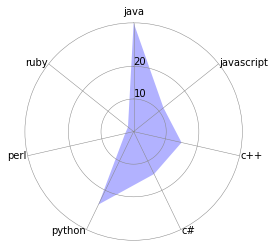

In [56]:
cat = ['java', 'javascript', 'c++', 'c#', 'python', 'perl', 'ruby']
values = [round(sum([month_frequency[month][c] for month in month_frequency])/376 * 100, 2) for c in cat]

N = len(cat)
x_as = [n / float(N) * 2 * pi for n in range(N)]

values += values[:1]
x_as += x_as[:1]

plt.rc('axes', linewidth=0.5, edgecolor="#888888")

ax = plt.subplot(111, polar=True)

ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

# Убираем стандартные метки
plt.xticks(x_as[:-1], [])

# Выводим шаг значения на график
plt.yticks([30, 60], ["10", "20"])

# Берем данные для диаграммы
ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

# Заполняем область под значениями
ax.fill(x_as, values, 'b', alpha=0.3)

# Ограничиваем области
plt.ylim(0, 100)

for i in range(N):
    angle_rad = i / float(N) * 2 * pi

    if angle_rad == 0:
        ha, distance_ax = "center", 10
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1

    ax.text(angle_rad, 100 + distance_ax, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")

plt.show()

### 3 Тип (популярность конкретной области в IT)

In [92]:
clusters_d = {'Python_Главный инженер по разработке': [74], 
     'Ведущий инженер по автоматизации тестирования': [27], 
     'Менеджер IT ( team leader)': [70], 
     'Главный инженер (сопровождение контактных центров; ELK)': [96], 
     'Главный инженер по разработке': [3, 4, 8, 9, 15, 16, 21, 23, 24, 25, 29, 30, 31, 34, 35, 37, 40, 41, 42, 43, 44, 54, 55, 59, 60, 63, 65, 68, 78, 79, 86, 87, 89, 95, 100, 101, 103, 104, 106, 107, 110, 111, 112, 114, 115, 119, 122, 129, 130, 131, 133, 134, 136, 140, 141, 142, 143, 145, 149, 151, 152, 153, 155, 157, 159, 163, 165, 166, 168, 169, 170, 171, 176, 177, 178, 179, 181, 183, 184, 185, 189, 190, 192, 198, 203, 204, 205, 206, 210, 211, 213, 214, 215, 218, 219, 221, 222, 225, 228, 230, 231, 233, 236, 237, 239, 240, 241, 244, 245, 248, 253, 254, 257, 258, 259, 260, 261, 262, 263, 264, 266, 269, 271, 272, 273, 274, 276, 277, 278, 279, 280, 282, 284, 285, 286, 287, 289, 293, 296, 298, 299, 300, 301, 302, 306, 308, 309, 312, 316, 317, 319, 324, 327, 328, 338, 341, 355, 361, 363, 364, 365, 366, 374, 376, 378, 381, 382, 384, 385, 390, 392, 393, 396, 397, 398, 399, 401, 402, 403, 407, 408, 411, 413, 414, 416, 418, 424, 428, 429, 430, 431, 432, 436, 438, 439, 440, 442, 443, 444, 448, 450, 451, 452, 453, 454, 455, 456, 458, 464, 465, 466, 468, 470, 471, 472, 473, 474, 475, 477, 479, 483, 486, 488, 490, 491, 492, 495, 497, 498, 501, 504, 505, 506, 508, 512, 513, 514, 515, 516, 517, 519, 525, 526, 529, 530, 531, 532, 533, 535, 536, 537, 538, 539, 542, 545, 547, 549, 550, 551, 553, 554, 556, 563, 564, 565, 567, 573, 575, 576, 577, 578, 580, 582, 583, 584, 585, 587, 592, 597, 599, 608, 614, 618, 625, 628, 639, 641, 644, 646, 647, 648, 651, 654, 656, 657, 660, 661, 662, 663, 668, 670, 672, 674, 675, 679, 682, 683, 686, 688, 689, 692, 694, 699, 700, 702, 703, 706, 707, 712, 713, 717, 719, 723, 726, 727, 729, 733, 735, 736, 741, 744, 746, 752, 756, 757, 764, 766, 768, 769, 778, 782, 783, 785, 786, 789, 791, 792, 801, 802, 804, 805, 808, 809, 816, 817, 819, 820, 821, 822, 823, 825, 827, 831, 832, 836, 839, 840, 843, 845, 849, 851, 852, 854, 858, 866, 874, 875, 887, 896, 898, 901, 906, 907, 908, 909, 910, 911, 914, 918, 919, 920, 923, 934, 936, 940, 941, 944, 945, 946, 947, 948, 949, 952, 955, 956, 958, 966, 971, 973, 974, 977, 980, 981, 982, 983, 984, 985, 987, 988, 989, 990, 991, 992, 1001, 1002, 1003, 1009, 1013, 1016, 1021, 1022, 1027, 1031, 1039, 1040, 1041, 1046, 1048, 1049, 1052, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1067, 1070, 1071, 1072, 1075, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1089, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1100, 1102, 1108, 1110, 1111, 1113, 1114, 1115, 1116, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1126, 1128, 1130, 1131, 1136, 1138, 1139, 1140, 1142, 1143, 1146, 1148, 1149, 1152, 1157, 1158, 1164, 1167, 1169, 1170, 1171, 1172, 1173, 1174, 1176, 1179, 1182, 1183, 1184, 1185, 1186, 1187, 1189, 1190, 1191, 1195, 1206, 1207, 1209], 
     'Full stack developer': [5, 19, 52, 90, 196, 307, 524, 588, 591, 594, 613, 626, 687, 691, 724, 799, 880, 926, 943, 1023], 
     'JavaScript разработчик': [1, 2], 
     'Эксперт Linux/Unix': [47], 
     'IOS разработчик': [53, 91, 148, 659], 
     'Системный аналитик': [6, 7, 11, 12, 13, 14, 17, 18, 20, 22, 26, 28, 32, 33, 38, 45, 46, 48, 51, 56, 57, 61, 64, 66, 67, 69, 71, 73, 75, 77, 84, 92, 93, 94, 98, 99, 102, 105, 108, 113, 116, 117, 118, 121, 123, 124, 125, 126, 127, 128, 132, 135, 137, 138, 144, 147, 150, 154, 156, 160, 161, 162, 164, 167, 172, 173, 175, 180, 182, 186, 187, 188, 191, 193, 195, 197, 199, 200, 201, 202, 207, 208, 212, 216, 217, 220, 223, 224, 226, 227, 229, 232, 234, 235, 238, 243, 246, 247, 255, 265, 267, 268, 270, 275, 281, 283, 288, 290, 291, 292, 294, 297, 303, 304, 305, 310, 311, 313, 314, 315, 318, 320, 321, 322, 323, 325, 326, 329, 330, 331, 332, 333, 334, 335, 336, 337, 339, 340, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 356, 357, 358, 359, 360, 362, 367, 368, 369, 370, 371, 372, 373, 375, 377, 379, 380, 383, 386, 387, 388, 389, 391, 394, 395, 400, 404, 405, 406, 409, 410, 412, 415, 417, 419, 420, 421, 422, 423, 425, 426, 427, 433, 434, 435, 437, 441, 445, 446, 447, 449, 457, 459, 460, 461, 462, 463, 467, 469, 476, 478, 480, 481, 482, 484, 485, 487, 489, 493, 494, 496, 499, 500, 502, 503, 507, 509, 510, 511, 518, 520, 521, 522, 523, 527, 528, 534, 540, 541, 543, 544, 546, 548, 552, 555, 557, 558, 559, 560, 561, 562, 566, 568, 569, 570, 571, 572, 574, 579, 581, 586, 589, 590, 593, 595, 596, 598, 600, 602, 603, 604, 605, 606, 607, 609, 610, 611, 612, 615, 616, 617, 619, 620, 621, 622, 623, 624, 627, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 642, 643, 645, 649, 650, 652, 653, 655, 658, 664, 665, 666, 667, 669, 671, 673, 676, 677, 678, 680, 681, 684, 685, 690, 693, 695, 696, 697, 698, 701, 704, 705, 708, 709, 710, 711, 714, 715, 716, 718, 720, 721, 722, 725, 728, 730, 731, 732, 734, 737, 738, 739, 740, 742, 743, 745, 747, 748, 749, 750, 751, 753, 754, 755, 758, 759, 760, 761, 762, 763, 765, 767, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 781, 784, 787, 788, 790, 793, 794, 795, 796, 797, 798, 800, 803, 806, 807, 810, 811, 812, 813, 814, 815, 818, 824, 826, 828, 830, 833, 834, 835, 837, 838, 842, 844, 846, 847, 848, 850, 853, 855, 856, 857, 859, 860, 861, 862, 863, 864, 865, 867, 868, 869, 870, 871, 872, 873, 876, 878, 879, 881, 882, 883, 884, 885, 886, 888, 889, 890, 891, 892, 893, 894, 895, 897, 899, 900, 902, 903, 904, 905, 912, 913, 915, 916, 917, 921, 922, 924, 925, 927, 928, 929, 930, 931, 932, 933, 935, 937, 938, 939, 942, 950, 951, 953, 954, 957, 959, 960, 961, 962, 963, 964, 965, 968, 969, 970, 972, 975, 976, 978, 979, 986, 993, 994, 995, 996, 997, 998, 999, 1000, 1004, 1005, 1006, 1007, 1008, 1010, 1011, 1012, 1014, 1015, 1017, 1018, 1019, 1020, 1024, 1025, 1026, 1028, 1029, 1030, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1042, 1043, 1044, 1045, 1047, 1051, 1053, 1054, 1055, 1056, 1066, 1068, 1069, 1073, 1074, 1076, 1077, 1086, 1087, 1088, 1090, 1098, 1099, 1101, 1103, 1104, 1105, 1106, 1107, 1109, 1112, 1125, 1127, 1129, 1132, 1133, 1134, 1135, 1137, 1141, 1144, 1145, 1150, 1151, 1153, 1154, 1155, 1156, 1159, 1160, 1161, 1162, 1163, 1165, 1166, 1168, 1175, 1177, 1178, 1180, 1181, 1188, 1192, 1193, 1194, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1208, 1210, 1212, 1213, 1214], 
     'Data scientist': [81], 
     'Главный инженер': [72], 
     'Java-разработчик': [36, 82, 109, 158], 
     'Инженер удаленной технической поддержки рабочих мест': [0], 
     'Администратор тестовых сред': [80, 256], 
     'Data Science': [85], 
     'Главный инженер по Java разработке': [10], 
     'ML Engineer / Python developer': [76], 
     'Java разработчик': [39, 49, 50, 58, 62, 88, 97, 120, 139, 146, 174, 194, 209, 242, 249, 250, 251, 252, 295, 601, 829, 841, 877, 967, 1050, 1117, 1147, 1211], 
     'Django разработчик': [83]
                 }

In [102]:
month_frequency_fields = {
    '01': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '02': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '03': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '04': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '05': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '06': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '07': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '08': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '09': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '10': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '11': {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
    '12': {'Главный инженер по разработке': 0, 'Системный аналитик': 0}
}

In [109]:
for i in range(len(final_db)):
    month = final_db[i][4][:10].split('-')[1]
    if i in clusters_d['Главный инженер по разработке']:
        month_frequency_fields[month]['Главный инженер по разработке'] += 1
    elif i in clusters_d['Системный аналитик']:
        month_frequency_fields[month]['Системный аналитик'] += 1

In [110]:
month_frequency_fields

{'01': {'Главный инженер по разработке': 77, 'Системный аналитик': 73},
 '02': {'Главный инженер по разработке': 91, 'Системный аналитик': 89},
 '03': {'Главный инженер по разработке': 60, 'Системный аналитик': 75},
 '04': {'Главный инженер по разработке': 66, 'Системный аналитик': 77},
 '05': {'Главный инженер по разработке': 48, 'Системный аналитик': 42},
 '06': {'Главный инженер по разработке': 35, 'Системный аналитик': 29},
 '07': {'Главный инженер по разработке': 23, 'Системный аналитик': 31},
 '08': {'Главный инженер по разработке': 29, 'Системный аналитик': 40},
 '09': {'Главный инженер по разработке': 31, 'Системный аналитик': 51},
 '10': {'Главный инженер по разработке': 27, 'Системный аналитик': 49},
 '11': {'Главный инженер по разработке': 29, 'Системный аналитик': 45},
 '12': {'Главный инженер по разработке': 9, 'Системный аналитик': 17}}

In [114]:
totals = {month: month_frequency_fields[month]['Главный инженер по разработке'] + month_frequency_fields[month]['Системный аналитик'] for month in month_frequency_fields}

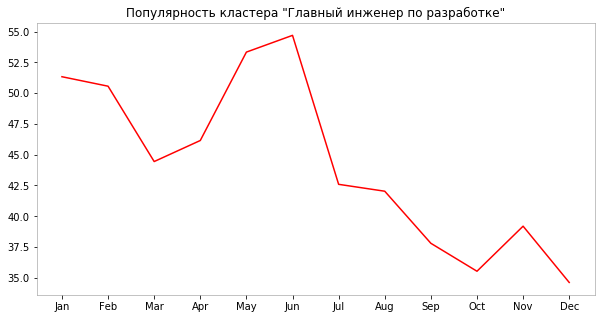

In [122]:
x = [month_names[x] for x in month_names]
y = [round(month_frequency_fields[month]['Главный инженер по разработке']/totals[month]* 100, 2) for month in month_frequency_fields]

plt.figure(figsize=(10, 5))
plt.plot(x, y, '-r')
plt.title('Популярность кластера "Главный инженер по разработке"')
plt.show()

In [107]:
[month_frequency_fields[month] for month in month_frequency_fields]

[{'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0},
 {'Главный инженер по разработке': 0, 'Системный аналитик': 0}]